In [608]:
class ROC:
    def __init__(self, Probs, TrueClass):
        self.Probs = Probs.copy()
        self.TrueClass = TrueClass.copy()
        # Get the number of instances in TrueClass which have a negative/positive label
        val_counts = TrueClass.value_counts()
        self.N = val_counts[0]
        self.P = val_counts[1]
        self.coords = None
    def compute_ROC_coordinates_original(self):
        tmp = pd.concat([self.Probs, self.TrueClass], axis=1)
        tmp.sort_values(by = [list(self.Probs.columns)[0]], ascending=False, axis=0, inplace=True)
        self.Probs = tmp[list(tmp.columns)[0]]
        self.TrueClass = tmp[list(tmp.columns)[1]]
        FP = 0
        TP = 0
        roc_coords = []
        prev_prob = -1
        equal_probs = []
        for i in range(len(self.Probs)):
            if(self.Probs.iloc[i] != prev_prob):
                roc_coords.append((FP/self.N, TP/self.P))
                prev_prob = self.Probs.iloc[i]
            if self.TrueClass.iloc[i] == "tested_positive":
                TP += 1
            else:
                FP += 1
        roc_coords.append((FP/self.N, TP/self.P))
        self.coords = roc_coords
        return roc_coords
    
    def compute_ROC_coordinates(self):
        #Sort
        tmp = pd.concat([self.Probs, self.TrueClass], axis=1)
        tmp.sort_values(by = [list(self.Probs.columns)[0]], ascending=False, axis=0, inplace=True)
        #Split again after sorting
        self.Probs = tmp[list(tmp.columns)[0]]
        self.TrueClass = tmp[list(tmp.columns)[1]]
        #Initialize variables needed
        FP = 0
        TP = 0
        roc_coords = []
        prev_prob = -1
        equal_probs = []
        for i in range(len(self.Probs)):
            #Building up the batch with equal probabilities
            if(self.Probs.iloc[i] == prev_prob):
                equal_probs.append(i)
            #If the batch ended...
            if(self.Probs.iloc[i] != prev_prob):
                #...process it...
                for index in equal_probs:
                    if self.TrueClass.iloc[index] == "tested_positive":
                        TP += 1
                    else:
                        FP += 1
                prev_prob = self.Probs.iloc[i]
                #...and start the new batch!
                equal_probs = [i]
                roc_coords.append((FP/self.N, TP/self.P))
        #If there is still some data in the batch that has not been processed...
        if len(equal_probs) > 0:
            #...process it too
            for index in equal_probs:
                if self.TrueClass.iloc[index] == "tested_positive":
                    TP += 1
                else:
                    FP += 1
            prev_prob = self.Probs.iloc[i]
            equal_probs = [i]
            roc_coords.append((FP/self.N, TP/self.P))
        self.coords = roc_coords
        return roc_coords
    def plot_roc(self):
        if(self.coords is None):
            raise ValueError("compute_roc_coordinates has to be run before plotting!")
        import matplotlib.pyplot as plt
        xs, ys = zip(*self.coords)
        plt.plot(xs, ys)
        plt.plot([0, 1], [0, 1], "--")
        
    def compute_AUCROC(self):
        if(self.coords is None):
            raise ValueError("compute_roc_coordinates has to be run before plotting!")
        FP = TP = 0
        prev_FP = prev_TP = 0
        A = 0
        prev_prob = -1
        for i in range(len(self.Probs)):
            if(self.Probs.iloc[i] != prev_prob):
                A += self.trapezoid_area(FP, prev_FP, TP, prev_TP)
                prev_prob = self.Probs.iloc[i]
                prev_FP = FP
                prev_TP = TP
            if self.TrueClass.iloc[i] == "tested_positive":
                TP += 1
            else:
                FP += 1
        A += self.trapezoid_area(1, prev_FP, 1, prev_TP)
        A /= (self.P * self.N)
        return A
    
    def trapezoid_area(self, x1, x2, y1, y2):
        return (abs(x1 - x2) * ((y1+y2) / 2))
    
    def getClassDistribution(self):
        return (self.P / (self.P + self.N), self.N / (self.N + self.P))

Area under curve (AUC): 0.6891464032421479


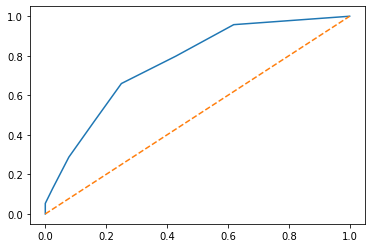

In [609]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
data = pd.read_csv("diabetes.csv")
Y = data["class"]
X = data.drop("class", axis=1)
# Normalization (afaik pandas automatically applies this column wise)
X=(X-X.min())/(X.max()-X.min())
#Splitting into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)
#Using a kNN classifier for testing purposes
clf = kNN(7)
clf.fit(X_train, Y_train)
# Predict the probabilities (classes are ordered in lexicographic order, so in this case [tested_negative, tested_positive])
Y_pred = clf.getClassProbs(X_test)
Y_pred = Y_pred.drop("tested_negative", axis=1)
#Y_pred = pd.DataFrame(data=Y_pred, columns=["tested_positive", "tested_negative"]).drop("tested_negative", axis=1)
Y_pred.index = Y_test.index
roc = ROC(Y_pred, Y_test)
coords = roc.compute_ROC_coordinates()
roc.plot_roc()
print("Area under curve (AUC): " + str(roc.compute_AUCROC()))

# Task b
What is done in the pseudocode is that they avoid the problem of having to deal with repetitions by simply skipping them. This, when looked at graphically, will always give the diagonal of a proposed rectangle of possible ROC lines (either all positive instances are at the top or all negative or they are mixed). What I did is processing the repeated instances batch-wise, so if we have 10 instances with equal probabilities, we take this batch, check how many positives and negatives there are in there and for every correctly classified instance we increase TP by 1, for each incorrectly classified instacne we increase FP by 1. I also had the idea that you could take the average of those batches and assign the average class to the whole batch, but this would greatly mess up the range of the ROC function, as TP/P and FP/N would not be bounded to be less than or equal to 1 anymore. I tried around a bit but did not get it to work in time, but I am pretty sure it can be done somehow.

In [610]:
# Class of k-Nearest Neigbor Classifier


class kNN():
    def __init__(self, k = 3, exp = 2):
    # constructor for kNN classifier 
    # k is the number of neighbor for local class estimation
    # exp is the exponent for the Minkowski distance
        self.k = k
        self.exp = exp
      
    def fit(self, X_train, Y_train):
    # training k-NN method
    # X_train is the training data given with input attributes. n-th row correponds to n-th instance.
    # Y_train is the output data (output vector): n-th element of Y_train is the output value for n-th instance in X_train.
        self.X_train = X_train
        self.Y_train = Y_train  
        #Get the number of classes and their instance numbers in Y_train (pre-computing this will prevent us from having to compute it 
        #every time we want to predict something)
        self.classNames = {}
        for className in Y_train:
            if not className in self.classNames:
                self.classNames[className] = 1
            else:
                self.classNames[className] += 1
         
    def getDiscreteClassification(self, X_test):
    # predict-class k-NN method
    # X_test is the test data given with input attributes. Rows correpond to instances
    # Method outputs prediction vector Y_pred_test:  n-th element of Y_pred_test is the prediction for n-th instance in X_test
        
        Y_pred_test = [] #prediction vector Y_pred_test for all the test instances in X_test is initialized to empty list []

   
        for i in range(len(X_test)):   #iterate over all instances in X_test
            test_instance = X_test.iloc[i] #i-th test instance 
            
            distances = []  #list of distances of the i-th test_instance for all the train_instance s in X_train, initially empty.
          
            for j in range(len(self.X_train)):  #iterate over all instances in X_train
                train_instance = self.X_train.iloc[j] #j-th training instance 
                distance = self.Minkowski_distance(test_instance, train_instance) #distance between i-th test instance and j-th training instance  
                distances.append(distance) #add the distance to the list of distances of the i-th test_instance
        
            # Store distances in a dataframe. The dataframe has the index of Y_train in order to keep the correspondence with the classes of the training instances 
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index = self.Y_train.index)
        
            # Sort distances, and only consider the k closest points in the new dataframe df_knn
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn =  df_nn[:self.k]
            
            # Note that the index df_knn.index of df_knn contains indices in Y_train of the k-closed training instances to 
            # the i-th test instance. Thus, the dataframe self.Y_train[df_knn.index] contains the classes of those k-closed 
            # training instances. Method value_counts() computes the counts (number of occurencies) for each class in 
            # self.Y_train[df_knn.index] in dataframe predictions. 
            predictions = self.Y_train[df_knn.index].value_counts()
            #print(self.Y_train[df_knn.index])     
            # the first element of the index predictions.index contains the class with the highest count; i.e. the prediction y_pred_test.
            y_pred_test = predictions.index[0]

            # add the prediction y_pred_test to the prediction vector Y_pred_test for all the test instances in X_test
            Y_pred_test.append(y_pred_test)
        
        return Y_pred_test

    
    def Minkowski_distance(self, x1, x2):
    # computes the Minkowski distance of x1 and x2 for two labeled instances (x1,y1) and (x2,y2)
    
        # Set initial distance to 0
        distance = 0
    
        # Calculate Minkowski distance using the exponent exp
        for i in range(len(x1)):
            distance = distance + abs(x1[i] - x2[i])**self.exp
        
        distance = distance**(1/self.exp)
    
        return distance
    
    
    #Task requires to have normalize as a function of kNN, so in order to prevent instantiating a new kNN object every time we need to normalize,
    # we can make it static
    @staticmethod
    def normalize(X):
        result = X.copy(deep=True)
        #For each columns...
        for col in X.columns:
            #...find the maximum value
            max_val = X[col].max()
            #...and divide the whole column by it to get a double value between 0 and 1
            result[col] /= max_val
        return result
    
    #getClassProbs method
    def getClassProbs(self, X_test):
        # X_test is the test data given with input attributes. Rows correpond to instances
        # Method outputs prediction dataframe Y_pred_test:  n-th element of Y_pred_test is the prediction vector with probabilities for n-th instance in X_test
        
        Y_pred_test = [] #prediction vector Y_pred_test for all the test instances in X_test is initialized to empty list []
        
        classNumber = len(self.classNames)
   
        for i in range(len(X_test)):   #iterate over all instances in X_test
            test_instance = X_test.iloc[i] #i-th test instance 
            
            distances = []  #list of distances of the i-th test_instance for all the train_instance s in X_train, initially empty.
          
            for j in range(len(self.X_train)):  #iterate over all instances in X_train
                train_instance = self.X_train.iloc[j] #j-th training instance 
                distance = self.Minkowski_distance(test_instance, train_instance) #distance between i-th test instance and j-th training instance  
                distances.append(distance) #add the distance to the list of distances of the i-th test_instance
        
            # Store distances in a dataframe. The dataframe has the index of Y_train in order to keep the correspondence with the classes of the training instances 
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index = self.Y_train.index)
        
            # Sort distances, and only consider the k closest points in the new dataframe df_knn
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn =  df_nn[:self.k]
            
            # Note that the index df_knn.index of df_knn contains indices in Y_train of the k-closed training instances to 
            # the i-th test instance. Thus, the dataframe self.Y_train[df_knn.index] contains the classes of those k-closed 
            # training instances. Method value_counts() computes the counts (number of occurencies) for each class in 
            # self.Y_train[df_knn.index] in dataframe predictions. 
            predictions = self.Y_train[df_knn.index].value_counts()
            y_pred_test_dict = {}
            for className in self.classNames:
                y_pred_test_dict[className] = 0
            # COmpute the probabilities
            for i in range(0, len(predictions)):
                y_pred_test_dict[predictions.index[i]] = predictions.iloc[i] / self.k
            # add the prediction y_pred_test to the prediction vector Y_pred_test for all the test instances in X_test
            Y_pred_test.append(y_pred_test_dict)
        Y_pred_test = pd.DataFrame(data = Y_pred_test)
        return Y_pred_test
    
    #Regression prediction
    def getPrediction(self, X_test):
        # X_test is the test data given with input attributes. Rows correpond to instances
        # Method outputs prediction vector Y_pred_test:  n-th element of Y_pred_test is the prediction for n-th instance in X_test
        
        Y_pred_test = [] #prediction vector Y_pred_test for all the test instances in X_test is initialized to empty list []

   
        for i in range(len(X_test)):   #iterate over all instances in X_test
            test_instance = X_test.iloc[i] #i-th test instance 
            
            distances = []  #list of distances of the i-th test_instance for all the train_instance s in X_train, initially empty.
          
            for j in range(len(self.X_train)):  #iterate over all instances in X_train
                train_instance = self.X_train.iloc[j] #j-th training instance 
                distance = self.Minkowski_distance(test_instance, train_instance) #distance between i-th test instance and j-th training instance  
                distances.append(distance) #add the distance to the list of distances of the i-th test_instance
        
            # Store distances in a dataframe. The dataframe has the index of Y_train in order to keep the correspondence with the classes of the training instances 
            df_dists = pd.DataFrame(data=distances, columns=['dist'], index = self.Y_train.index)
        
            # Sort distances, and only consider the k closest points in the new dataframe df_knn
            df_nn = df_dists.sort_values(by=['dist'], axis=0)
            df_knn =  df_nn[:self.k]
            result = 0
            for i in range(0, self.k):
                result += Y_train[df_knn.index[i]]
            result /= self.k
            # add the prediction y_pred_test to the prediction vector Y_pred_test for all the test instances in X_test
            Y_pred_test.append(result)
        
        return Y_pred_test

Area under curve (AUC): 0.6891464032421479
Area under curve (AUC): 1.305724417426545


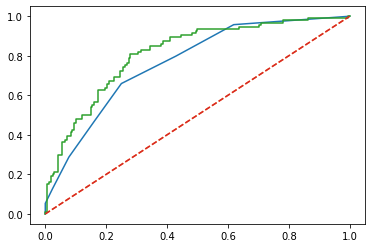

In [611]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
data = pd.read_csv("diabetes.csv")
Y = data["class"]
X = data.drop("class", axis=1)
# Normalization (afaik pandas automatically applies this column wise)
X=(X-X.min())/(X.max()-X.min())
#Splitting into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)
#Using a kNN classifier for testing purposes
clf = kNN(7)
clf2 = LogisticRegression()
clf.fit(X_train, Y_train)
clf2.fit(X_train, Y_train)
# Predict the probabilities (classes are ordered in lexicographic order, so in this case [tested_negative, tested_positive])
Y_pred = clf.getClassProbs(X_test)
Y_pred2 = clf2.predict_proba(X_test)
Y_pred = Y_pred.drop("tested_negative", axis=1)
Y_pred2 = pd.DataFrame(data=Y_pred2, columns=["tested_negative", "tested_positive"]).drop("tested_negative", axis=1)
Y_pred.index = Y_test.index
Y_pred2.index = Y_test.index
roc = ROC(Y_pred, Y_test)
roc2 = ROC(Y_pred2, Y_test)
coords = roc.compute_ROC_coordinates()
coords2 = roc2.compute_ROC_coordinates()
roc.plot_roc()
roc2.plot_roc()
print("Area under curve (AUC): " + str(roc.compute_AUCROC()))
print("Area under curve (AUC): " + str(roc2.compute_AUCROC()))

In [844]:
#predictions is a dict containing the predictions on data for each classifier
def compute_ROC_convex_hull_coordinates(predictions, TrueClasses):
    #(0, 0) and (1, 1) are always part of the convex hull
    rocch_coords = pd.DataFrame(columns = ["FPr", "TPr", "name"])
    #Don't know if i will finish this
    #For sorting the points (to not mess up the drawing)
    df = pd.DataFrame([[0, 0, None]], columns=["FPr", "TPr", "name"])
    for clf in predictions:
        FPr, TPr, acc = getOptimalClassDistribution(predictions[clf], TrueClasses)
        row_df = pd.DataFrame([[FPr, TPr, clf]], columns=["FPr", "TPr", "name"])
        df = df.append(row_df)
    df.sort_values(by = ["FPr"], axis=0, inplace=True)
    coords = df.drop("name", axis=1)
    dominated = {}
    for i in range(len(coords)):
        dominated[i] = False
        for j in range(len(coords)):
            if i != j:
                if(dominates(coords.iloc[j], coords.iloc[i])):
                    dominated[i] = True
                    break
        if not dominated[i]:
            row_df = pd.DataFrame([df.iloc[i]], columns=["FPr", "TPr", "name"])
            rocch_coords = rocch_coords.append(row_df)
    #(0, 0) and (1, 1) are always part of the convex hull
    print(dominated)
    row_df = pd.DataFrame([[1, 1, None]], columns=["FPr", "TPr", "name"])
    df = df.append(row_df)
    rocch_coords = rocch_coords.append(row_df)
    return rocch_coords, df

#Returns true if clf1 dominates clf2, false otherwise
def dominates(clf1, clf2):
    return (clf1[1] > clf2[1] and clf1[0] <= clf2[0])

#Gets the classifier with the optimal ISO accuracy on its ROC curve
def getOptimalClassDistribution(prediction, TrueClasses):
    #Iso line scan here to find the best performance of the classifier
    roc = ROC(prediction, TrueClasses)
    pos, neg = roc.getClassDistribution()
    coords = roc.compute_ROC_coordinates()
    record_acc = 0
    record_points = (-1, -1)
    for x, y in coords:
        acc = getIsoScore(x, y, pos, neg)
        if acc > record_acc:
            record_acc = acc
            record_points = (x, y, acc)
    return record_points

#Gets the ISO accuracy of the given classifier
def getIsoScore(x, y, pos, neg):
    return y * pos + neg - neg * x
            

{0: False, 1: False, 2: False, 3: True, 4: False, 5: False, 6: True}
        FPr       TPr   name
0  0.000000  0.000000   None
0  0.000000  0.000000  bogus
0  0.065476  0.457447    svc
0  0.071429  0.361702     DT
0  0.172619  0.627660     lr
0  0.232143  0.734043    MLP
0  0.250000  0.659574    knn
0  1.000000  1.000000   None


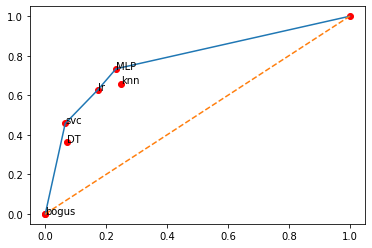

In [845]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np

data = pd.read_csv("diabetes.csv")
Y = data["class"]
X = data.drop("class", axis=1)

# Normalization (afaik pandas automatically applies this column wise)
X=(X-X.min())/(X.max()-X.min())

#Splitting into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

#Using different classifiers for testing purposes
clfs = [KNeighborsClassifier(7), LogisticRegression(), SVC(probability=True), DecisionTreeClassifier(max_depth=5), MLPClassifier(alpha=1, max_iter=1000)]
Y_preds = []
for clf in clfs:
    #Fitting
    clf.fit(X_train, Y_train)
    # Predicting
    Y_pred = clf.predict_proba(X_test)
    #Preparing the predictions as a df
    Y_pred = pd.DataFrame(data=Y_pred, columns=["tested_negative", "tested_positive"]).drop("tested_negative", axis=1)
    Y_preds.append(Y_pred)
    Y_pred.index = Y_test.index

    
#Bogus classifier
sample = [0.3 for i in range(len(Y_test))]
sample = zip(sample, sample)
sample = pd.DataFrame(data=sample, columns=["tested_negative", "tested_positive"]).drop("tested_negative", axis=1)
Y_preds.append(sample)
sample.index = Y_test.index
clf_dict = {
    "knn": Y_preds[0],
    "lr": Y_preds[1],
    "svc": Y_preds[2],
    "DT": Y_preds[3],
    "MLP": Y_preds[4],
    "bogus": Y_preds[5]
}
clfs, all_clfs = compute_ROC_convex_hull_coordinates(clf_dict, Y_test)
coords = clfs.drop(["name"], axis=1)
print(all_clfs)
xs = coords["FPr"]
ys = coords["TPr"]
#Draw roc curve and their optimal classifier
for i in range(len(all_clfs)):
    plt.plot(all_clfs["FPr"].iloc[i], all_clfs["TPr"].iloc[i], "ro")
    plt.annotate(all_clfs["name"].iloc[i], (all_clfs["FPr"].iloc[i], all_clfs["TPr"].iloc[i]))
plt.plot(xs, ys, "-")
plt.plot([0, 1], [0, 1], "--")

## Task F
Above is the implementation and testing for task f. We first compute the optimal class distribution per classifier by calculating the ISO-accuracy on every point of the respective classifier's ROC-curve. We then take the point with the highest ISO-accuracy and check for dominance by other classifiers. Only the classifiers which arenot dominated by any other other classifier form the Pareto front, aka the convex hull. The other classifiers are still shown, they are not optimal however and therefore not on the ROCCH. I encountered a problem when trying to purposefully creating a bogus classifier which sits right inside the convex hull, but the bogus classifier with best performance is always the one with TPr = FPr = 0. This was unexpected at first, but upon further thinking seems reasonable, since, when the ROC curve for the bogus classifier is drawn, it performs exactly randomly, since it lies on the line TPr = FPr and therefore the accuracy on this dataset split (where there are more negative than positive examples) is best at this point. There are some problems where sometimes the hull is not necessarily convex, especially when TPr_A > TPr_B and !(FPr_A < FPr_B), leading to the domination method returning that A is not dominating B (an example of this behaviour is seen sometimes when MLP and knn are really close in FPr, but FPr_MLP > FPr_knn and TPr_MLP < TPr_knn).